In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import OneHotEncoder, CatBoostEncoder, MEstimateEncoder
from sklearn.model_selection import StratifiedGroupKFold, train_test_split


from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression

from sklearn import set_config
import os
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from sklearn.model_selection import StratifiedKFold
import optuna
from sklearn.compose import ColumnTransformer
from prettytable import PrettyTable

from sklearn.compose import make_column_transformer
from sklearn.base import clone
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## load data

In [2]:
data = pd.read_csv("data/data.csv")
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
raw = pd.read_csv("data/ObesityDataSet_raw_and_data_sinthetic.csv")
submission = pd.read_csv("data/sample_submission.csv")

data.shape, train.shape, test.shape, test.shape, raw.shape, submission.shape

((50001, 18), (20758, 18), (13840, 17), (13840, 17), (2111, 17), (13840, 2))

## bmi 생성

In [3]:
train['BMI'] = train['Weight'] / (train['Height']**2)
test['BMI'] = test['Weight'] / (test['Height']**2)
data['BMI'] = data['Weight'] / (data['Height']**2)
raw['BMI'] = raw['Weight'] / (raw['Height']**2)

In [4]:
train.drop("id", axis=1, inplace=True)
test.drop("id", axis=1, inplace=True)

In [5]:
categories = train.columns[(train.dtypes=="object") & (train.columns != "NObeyesdad")]
for cat in categories:
    le = LabelEncoder()
    print(cat)
    if train[cat].dtypes == "object":
        le = le.fit(train[cat])
        train[cat] = le.transform(train[cat])

Gender
family_history_with_overweight
FAVC
CAEC
SMOKE
SCC
CALC
MTRANS


In [6]:
rcats = raw.columns[(raw.dtypes=="object") & (raw.columns != "NObeyesdad")]
for rcat in rcats:
    le = LabelEncoder()
    print(rcat)
    if raw[rcat].dtypes == "object":
        le = le.fit(raw[rcat])
        raw[rcat] = le.transform(raw[rcat])

Gender
family_history_with_overweight
FAVC
CAEC
SMOKE
SCC
CALC
MTRANS


In [7]:
tcats = test.columns[test.dtypes=="object"]
for tcat in tcats:
    le = LabelEncoder()
    print(tcat)
    if test[tcat].dtypes == "object":
        le = le.fit(test[tcat])
        test[tcat] = le.transform(test[tcat])

Gender
family_history_with_overweight
FAVC
CAEC
SMOKE
SCC
CALC
MTRANS


In [8]:
train.head(1)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI
0,1,24.443011,1.699998,81.66995,1,1,2.0,2.983297,2,0,2.763573,0,0.0,0.976473,1,3,Overweight_Level_II,28.259565


In [9]:
raw.head(1)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI
0,0,21.0,1.62,64.0,1,0,2.0,3.0,2,0,2.0,0,0.0,1.0,3,3,Normal_Weight,24.386526


In [10]:
test.head(1)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,BMI
0,1,26.899886,1.848294,120.644178,1,1,2.938616,3.0,2,0,2.825629,0,0.8554,0.0,2,3,35.315411


In [11]:
data.drop("Unnamed: 0", axis=1, inplace=True)

In [12]:
data.head(1)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI
0,1,24.443011,1.699998,81.66995,1,1,2.0,2.983297,2,0,2.763573,0,0.0,0.976473,1,3,6,28.259565


In [13]:
nobeyesdad_mapping = {'Insufficient_Weight': 0, 
                      'Normal_Weight': 1, 
                      'Obesity_Type_I': 2, 
                      'Obesity_Type_II': 3, 
                      'Obesity_Type_III': 4,
                      'Overweight_Level_I': 5, 
                      'Overweight_Level_II': 6} 


train['NObeyesdad'] = train['NObeyesdad'].map(nobeyesdad_mapping)
raw['NObeyesdad'] = raw['NObeyesdad'].map(nobeyesdad_mapping)

In [14]:
train.head(1)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI
0,1,24.443011,1.699998,81.66995,1,1,2.0,2.983297,2,0,2.763573,0,0.0,0.976473,1,3,6,28.259565


In [15]:
raw.head(1)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI
0,0,21.0,1.62,64.0,1,0,2.0,3.0,2,0,2.0,0,0.0,1.0,3,3,1,24.386526


## 변수 분리

In [16]:
# 타겟 변수와 피처 분리
train_X = train.drop('NObeyesdad', axis=1)
train_Y = train['NObeyesdad']
data_X = data.drop('NObeyesdad', axis=1)
data_Y = data['NObeyesdad']
raw_X = raw.drop('NObeyesdad', axis=1)
raw_Y = raw['NObeyesdad']

# 학습 세트와 테스트 세트로 분할
X_tr, X_val, y_tr, y_val = train_test_split(data_X, data_Y, test_size=0.2, random_state=42)

X_tr.shape, X_val.shape, y_tr.shape, y_val.shape

((40000, 17), (10001, 17), (40000,), (10001,))

In [17]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []

for fold, (train_index, val_index) in enumerate(skf.split(X_tr, y_tr), 1):

    X_train_fold, X_val_fold = X_tr.iloc[train_index], X_tr.iloc[val_index]
    y_train_fold, y_val_fold = y_tr.iloc[train_index], y_tr.iloc[val_index]

    model_xgb = XGBClassifier(random_state=42)
    model_xgb.fit(X_train_fold, y_train_fold)

    y_pred_fold = model_xgb.predict(X_val_fold)
    accuracy_fold = accuracy_score(y_val_fold, y_pred_fold)
    accuracies.append(accuracy_fold)

    print(f"Fold {fold} (XGBoost) 검증 데이터 정확도: {accuracy_fold:.6f}")

average_accuracy = np.mean(accuracies)
print(f"\n평균 (XGBoost) 검증 데이터 정확도: {average_accuracy:.6f}")

Fold 1 (XGBoost) 검증 데이터 정확도: 0.938375
Fold 2 (XGBoost) 검증 데이터 정확도: 0.930250
Fold 3 (XGBoost) 검증 데이터 정확도: 0.929375
Fold 4 (XGBoost) 검증 데이터 정확도: 0.928750
Fold 5 (XGBoost) 검증 데이터 정확도: 0.940625

평균 (XGBoost) 검증 데이터 정확도: 0.933475


In [18]:
from lightgbm import LGBMClassifier

accuracies_lgb = []

for fold, (train_index, val_index) in enumerate(skf.split(X_tr, y_tr), 1):
    X_train_fold, X_val_fold = X_tr.iloc[train_index], X_tr.iloc[val_index]
    y_train_fold, y_val_fold = y_tr.iloc[train_index], y_tr.iloc[val_index]

    model_lgb = LGBMClassifier(random_state=42, verbose=-1)
    model_lgb.fit(X_train_fold, y_train_fold)

    y_pred_fold = model_lgb.predict(X_val_fold)
    accuracy_fold = accuracy_score(y_val_fold, y_pred_fold)
    accuracies_lgb.append(accuracy_fold)

    print(f"Fold {fold} (LightGBM) 검증 데이터 정확도: {accuracy_fold:.6f}")

average_accuracy_lgb = np.mean(accuracies_lgb)
print(f"\n평균 (LightGBM) 검증 데이터 정확도: {average_accuracy_lgb:.6f}")

Fold 1 (LightGBM) 검증 데이터 정확도: 0.937500
Fold 2 (LightGBM) 검증 데이터 정확도: 0.927250
Fold 3 (LightGBM) 검증 데이터 정확도: 0.930125
Fold 4 (LightGBM) 검증 데이터 정확도: 0.928625
Fold 5 (LightGBM) 검증 데이터 정확도: 0.936875

평균 (LightGBM) 검증 데이터 정확도: 0.932075


In [19]:
accuracies_rf = []

for fold, (train_index, val_index) in enumerate(skf.split(X_tr, y_tr), 1):
    X_train_fold, X_val_fold = X_tr.iloc[train_index], X_tr.iloc[val_index]
    y_train_fold, y_val_fold = y_tr.iloc[train_index], y_tr.iloc[val_index]

    model_rf = RandomForestClassifier(random_state=42)
    model_rf.fit(X_train_fold, y_train_fold)

    y_pred_fold = model_rf.predict(X_val_fold)
    accuracy_fold = accuracy_score(y_val_fold, y_pred_fold)
    accuracies_rf.append(accuracy_fold)

    print(f"Fold {fold} (RandomForest) 검증 데이터 정확도: {accuracy_fold:.6f}")

average_accuracy_rf = np.mean(accuracies_rf)
print(f"\n평균 (RandomForest) 검증 데이터 정확도: {average_accuracy_rf:.6f}")

Fold 1 (RandomForest) 검증 데이터 정확도: 0.935500
Fold 2 (RandomForest) 검증 데이터 정확도: 0.928125
Fold 3 (RandomForest) 검증 데이터 정확도: 0.929750
Fold 4 (RandomForest) 검증 데이터 정확도: 0.929875
Fold 5 (RandomForest) 검증 데이터 정확도: 0.937375

평균 (RandomForest) 검증 데이터 정확도: 0.932125


In [20]:
accuracies_cat = []

for fold, (train_index, val_index) in enumerate(skf.split(X_tr, y_tr), 1):
    X_train_fold, X_val_fold = X_tr.iloc[train_index], X_tr.iloc[val_index]
    y_train_fold, y_val_fold = y_tr.iloc[train_index], y_tr.iloc[val_index]

    model_cat = CatBoostClassifier(random_state=42, verbose=0)
    model_cat.fit(X_train_fold, y_train_fold)

    y_pred_fold = model_cat.predict(X_val_fold)
    accuracy_fold = accuracy_score(y_val_fold, y_pred_fold)
    accuracies_cat.append(accuracy_fold)

    print(f"Fold {fold} (CatBoost) 검증 데이터 정확도: {accuracy_fold:.6f}")

average_accuracy_cat = np.mean(accuracies_cat)
print(f"\n평균 (CatBoost) 검증 데이터 정확도: {average_accuracy_cat:.6f}")

Fold 1 (CatBoost) 검증 데이터 정확도: 0.936125
Fold 2 (CatBoost) 검증 데이터 정확도: 0.927125
Fold 3 (CatBoost) 검증 데이터 정확도: 0.927750
Fold 4 (CatBoost) 검증 데이터 정확도: 0.926875
Fold 5 (CatBoost) 검증 데이터 정확도: 0.933875

평균 (CatBoost) 검증 데이터 정확도: 0.930350


In [21]:
raw_preds_xgb = model_xgb.predict(raw_X)
raw_preds_lgb = model_lgb.predict(raw_X)
raw_preds_rf = model_rf.predict(raw_X)
raw_preds_cat = model_cat.predict(raw_X)

raw_accuracy_xgb = accuracy_score(raw_Y, raw_preds_xgb)
raw_accuracy_lgb = accuracy_score(raw_Y, raw_preds_lgb)
raw_accuracy_rf = accuracy_score(raw_Y, raw_preds_rf)
raw_accuracy_cat = accuracy_score(raw_Y, raw_preds_cat)

print("XGBoost 학습 데이터 정확도:", raw_accuracy_xgb)
print("LightGBM 학습 데이터 정확도:", raw_accuracy_lgb)
print("RandomForest 학습 데이터 정확도:", raw_accuracy_rf)
print("CatBoost 학습 데이터 정확도:", raw_accuracy_cat)

XGBoost 학습 데이터 정확도: 0.994789199431549
LightGBM 학습 데이터 정확도: 0.9928943628612033
RandomForest 학습 데이터 정확도: 0.995736617716722
CatBoost 학습 데이터 정확도: 0.9900521080056846


In [22]:
pred_xgb = model_xgb.predict(train_X)
accuracy_xgb = accuracy_score(train_Y, pred_xgb)
print("XGBoost 학습 데이터 정확도:", accuracy_xgb)

pred_lgb = model_lgb.predict(train_X)
accuracy_lgb = accuracy_score(train_Y, pred_lgb)
print("LightGBM 학습 데이터 정확도:", accuracy_lgb)

pred_rf = model_rf.predict(train_X)
accuracy_rf = accuracy_score(train_Y, pred_rf)
print("RandomForest 학습 데이터 정확도:", accuracy_rf)

pred_cat = model_cat.predict(train_X)
accuracy_cat = accuracy_score(train_Y, pred_cat)
print("CatBoost 학습 데이터 정확도:", accuracy_cat)

XGBoost 학습 데이터 정확도: 0.9585220156084401
LightGBM 학습 데이터 정확도: 0.9477309952789286
RandomForest 학습 데이터 정확도: 0.9660853646786781
CatBoost 학습 데이터 정확도: 0.9383852008864052


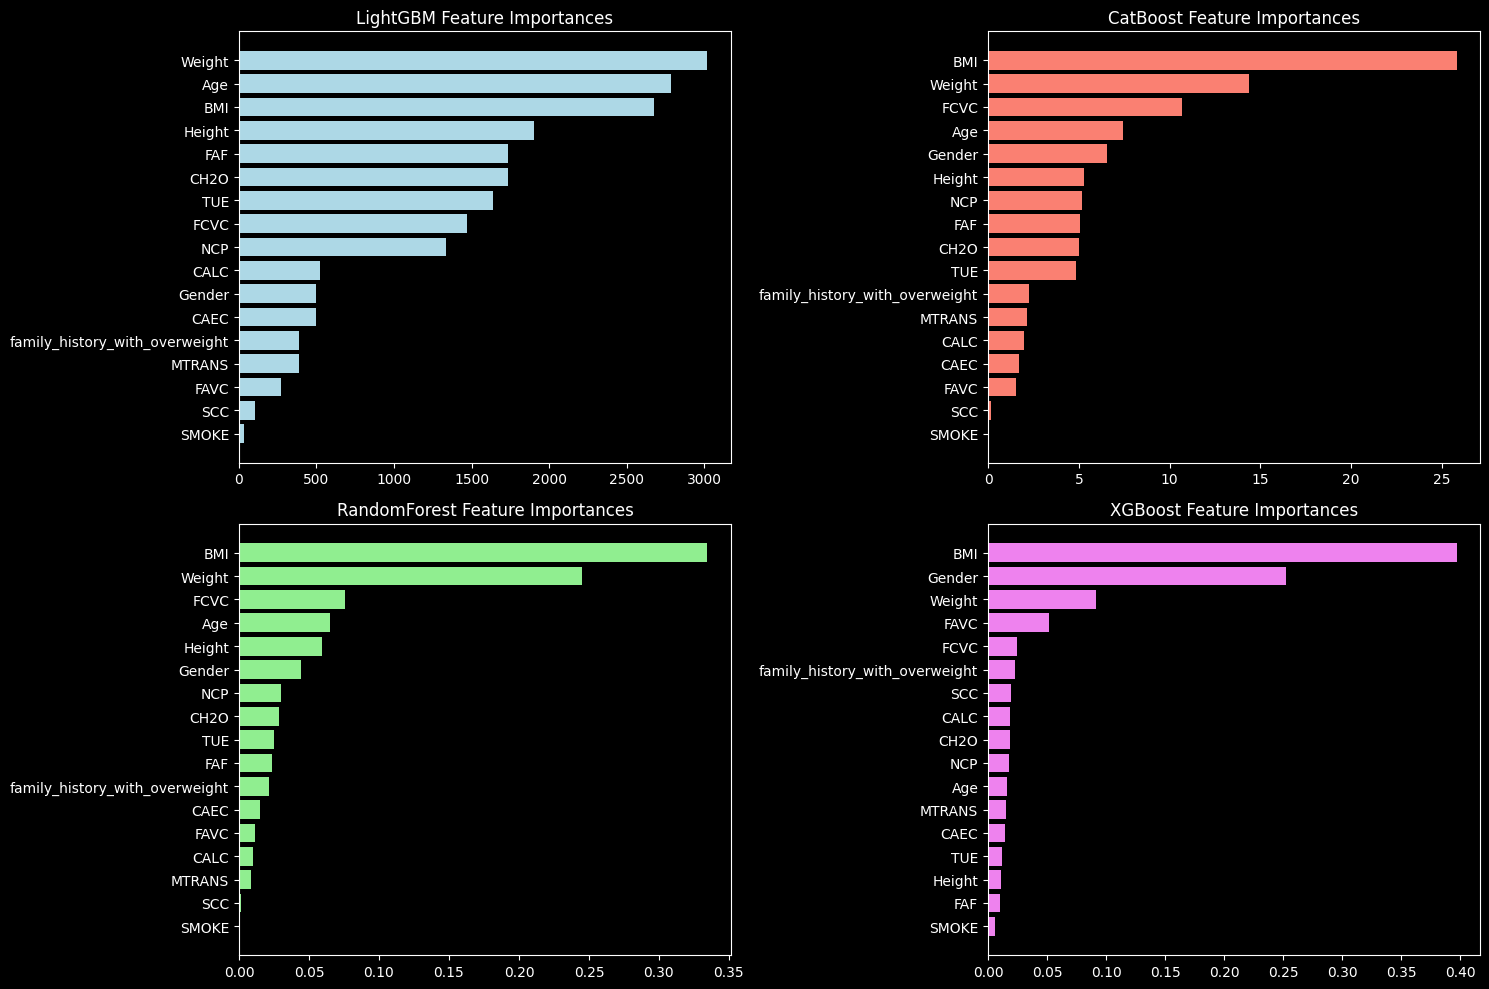

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# 다크 모드 스타일 사용
plt.style.use('dark_background')

# 실제 데이터셋의 특성 이름을 사용
feature_names = train_X.columns

cat_importances = model_cat.feature_importances_
rf_importances = model_rf.feature_importances_
xgb_importances = model_xgb.feature_importances_
lgb_importances = model_lgb.feature_importances_


# 각 모델의 중요도에 따른 인덱스 정렬
lgb_indices = np.argsort(lgb_importances)
cat_indices = np.argsort(cat_importances)
rf_indices = np.argsort(rf_importances)
xgb_indices = np.argsort(xgb_importances)

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# LightGBM Feature Importances
axs[0, 0].barh(range(len(lgb_indices)), lgb_importances[lgb_indices], color='lightblue')
axs[0, 0].set_yticks(range(len(lgb_indices)))
axs[0, 0].set_yticklabels(np.array(feature_names)[lgb_indices])
axs[0, 0].set_title('LightGBM Feature Importances')

# CatBoost Feature Importances
axs[0, 1].barh(range(len(cat_indices)), cat_importances[cat_indices], color='salmon')
axs[0, 1].set_yticks(range(len(cat_indices)))
axs[0, 1].set_yticklabels(np.array(feature_names)[cat_indices])
axs[0, 1].set_title('CatBoost Feature Importances')

# RandomForest Feature Importances
axs[1, 0].barh(range(len(rf_indices)), rf_importances[rf_indices], color='lightgreen')
axs[1, 0].set_yticks(range(len(rf_indices)))
axs[1, 0].set_yticklabels(np.array(feature_names)[rf_indices])
axs[1, 0].set_title('RandomForest Feature Importances')

# XGBoost Feature Importances
axs[1, 1].barh(range(len(xgb_indices)), xgb_importances[xgb_indices], color='violet')
axs[1, 1].set_yticks(range(len(xgb_indices)))
axs[1, 1].set_yticklabels(np.array(feature_names)[xgb_indices])
axs[1, 1].set_title('XGBoost Feature Importances')

plt.tight_layout()
plt.show()

In [24]:
xgb_preds = model_xgb.predict(test)
lgb_preds = model_lgb.predict(test)
rf_preds = model_rf.predict(test)
cat_preds = model_cat.predict(test)

In [25]:
category_mapping = {
    0: 'Insufficient_Weight',
    1: 'Normal_Weight',
    2: 'Obesity_Type_I',
    3: 'Obesity_Type_II',
    4: 'Obesity_Type_III',
    5: 'Overweight_Level_I',
    6: 'Overweight_Level_II'
}

In [26]:
xgb_preds_names = [category_mapping[pred] for pred in xgb_preds]
lgb_preds_names = [category_mapping[pred] for pred in lgb_preds]
rf_preds_names = [category_mapping[pred] for pred in rf_preds]
cat_preds_names = [category_mapping[pred] for pred in cat_preds]

TypeError: unhashable type: 'numpy.ndarray'

In [ ]:
submission['NObeyesdad'] = xgb_preds_names
submission

In [ ]:
submission.to_csv("submission_xgb.csv", index=False)

In [ ]:
submission['NObeyesdad'] = lgb_preds_names
submission

In [ ]:
submission.to_csv("submission_lgb.csv", index=False)

In [ ]:
submission['NObeyesdad'] = rf_preds_names
submission

In [ ]:
submission.to_csv("submission_rf.csv", index=False)

In [ ]:
submission['NObeyesdad'] = cat_preds_names
submission

In [ ]:
submission.to_csv("submission_cat.csv", index=False)